In [1]:
import config
import mysql.connector
from clickhouse_sqlalchemy import make_session
from sqlalchemy import create_engine
cnf = config.cnf()

In [2]:
connection = 'clickhouse://{user}:{password}@{server_host}:{port}/{db}'.format(**cnf.click_conf)
engine = create_engine(connection, pool_size=100, pool_recycle=3600, pool_timeout=20)
session = make_session(engine)

In [3]:
cursor = session.execute('SELECT * FROM audit_record limit 10')
# cursor.fetchall()[0]

In [25]:
cursor.fetchone()[0]

4245021

In [3]:
def test(*args,**kwargs):
    print(args)
    print(kwargs)
test(1,3,5,7,c='2',d=4)


(1, 3, 5, 7)
{'c': '2', 'd': 4}


In [4]:
test(**cnf.click_conf)

()
{'user': 'root', 'password': 'Ankki_cK123', 'server_host': '172.24.4.85', 'port': '8123', 'db': 'bs_audit', 'tabel': 'audit_record'}


In [9]:
try:
    mydb = mysql.connector.connect(
                **cnf.mysql_conf
            )
except Exception as e:
    print(e)

In [10]:
mycursor = mydb.cursor()
mycursor.execute("SELECT template FROM sql_template_record where id='7176854313362588233'")
# mycursor.execute('SELECT count(1) FROM sql_template_record')

In [6]:
mycursor.execute('SELECT count(1) FROM sql_template_record')

In [11]:
re = mycursor.fetchall()

In [12]:
re[0][0]

'SELECT locked FROM zt_user WHERE account = ?'

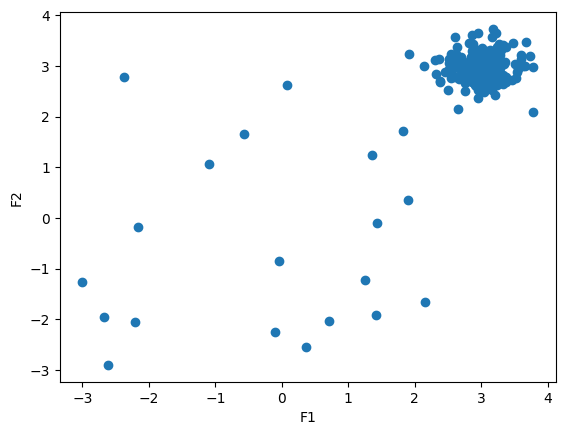


1 fitting ABOD

2 fitting ECOD

3 fitting CBLOF

4 fitting HBOS

5 fitting IForest

6 fitting KNN

7 fitting LOF

8 fitting MCD

9 fitting OCSVM

10 fitting PCA


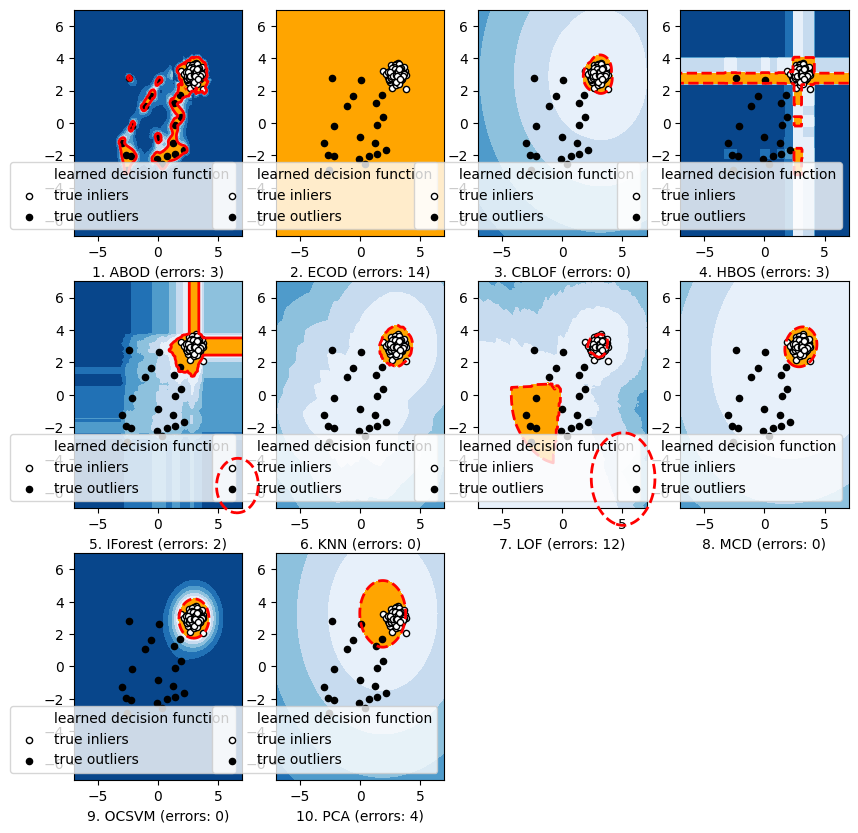

In [2]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
"""
@File    :   outlierDetection.py    
@Modify Time      @Author    @Version    @Description
------------      -------    --------    -----------
2021/8/12 14:06   SeafyLiang   1.0       离群点检测pyod
"""
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
# 检测数据集中异常值的模型
from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.models.cblof import CBLOF
# from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
# from pyod.models.loci import LOCI
# from pyod.models.sod import SOD
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.utils.data import generate_data, get_outliers_inliers

"""
参考资料：
https://blog.csdn.net/weixin_41697507/article/details/89408236
https://blog.csdn.net/sparkexpert/article/details/81195418
https://github.com/yzhao062/Pyod#ramaswamy2000efficient
"""

# 创建一个带有异常值的随机数据集并绘制它
# generate random data with two features
X_train, Y_train = generate_data(n_train=200, train_only=True, n_features=2)
# by default the outlier fraction is 0.1 in generate data function
outlier_fraction = 0.1
# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train, Y_train)
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)
# separate the two features and use it to plot the data
F1 = X_train[:, [0]].reshape(-1, 1)
F2 = X_train[:, [1]].reshape(-1, 1)
# create a meshgrid
xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
# scatter plot
plt.scatter(F1, F2)
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()

"""
Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Fast outlier detection using the local correlation integral(LOCI)
Model 8 Subspace Outlier Detection (SOD)
Model 9 Local Outlier Factor (LOF)
Model 10 Minimum Covariance Determinant (MCD)
Model 11 One-class SVM (OCSVM)
Model 12 Principal Component Analysis (PCA)
"""
# 创建一个dictionary并添加要用于检测异常值的所有模型
classifiers = {
    'ABOD': ABOD(contamination=outlier_fraction),
    'ECOD': ECOD(contamination=outlier_fraction),
    'CBLOF': CBLOF(contamination=outlier_fraction),
    # 'Feature Bagging': FeatureBagging(contamination=outlier_fraction),
    'HBOS': HBOS(contamination=outlier_fraction),
    'IForest': IForest(contamination=outlier_fraction),
    'KNN': KNN(contamination=outlier_fraction),
    # 'LOCI': LOCI(contamination=outlier_fraction, ),
    # 'SOD': SOD(contamination=outlier_fraction, ),
    'LOF': LOF(contamination=outlier_fraction, ),
    'MCD': MCD(contamination=outlier_fraction, ),
    'OCSVM': OCSVM(contamination=outlier_fraction, ),
    'PCA': PCA(contamination=outlier_fraction, ),

}
# 将数据拟合到我们在dictionary中添加的每个模型，然后，查看每个模型如何检测异常值
# set the figure size

plt.figure(figsize=(10, 10))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print()
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X_train)
    scores_pred = clf.decision_function(X_train) * -1
    y_pred = clf.predict(X_train)
    threshold = stats.scoreatpercentile(scores_pred,
                                        100 * outlier_fraction)
    n_errors = (y_pred != Y_train).sum()
    # plot the levels lines and the points

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(3, 4, i + 1)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                     cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                        linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                     colors='orange')
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',
                        s=20, edgecolor='k')
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',
                        s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
plt.show()



In [16]:
dc={1:8,2:3}
for i in dc:
    print(i)

1
2


In [15]:
for i,j in zip(dc,range(2)):
    print(i,j)

1 0
2 1


In [5]:
ed = ECOD(contamination=0.1)
ed.fit(X_train)

ECOD(contamination=0.1, n_jobs=1)

In [93]:
import pandas as pd
df = pd.read_csv('fw.csv')
df.head()

,Unnamed: 0,time_hm,size
0,0,0,1
1,1,1,2
2,2,2,4
3,3,3,3
4,4,4,1


In [116]:
y

array([0.0001, 0.0002, 0.0004, ..., 0.0001, 0.0001, 0.0002])

In [130]:
X = df['time_hm'].values.reshape(-1,1)
y=df['size'].values
# y = y/y.sum()

In [131]:
from sklearn.svm import NuSVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
# n_samples, n_features = 100, 1
# np.random.seed(0)
# y = np.random.randn(n_samples)
# # X = np.random.randn(n_samples, n_features)
# X = np.arange(n_samples).reshape(-1,1)
regr = make_pipeline(StandardScaler(), NuSVR(C=1, nu=0.5, gamma=20))
# regr = NuSVR(C=0.1, nu=0.5, gamma=0.1)
# regr = make_pipeline(StandardScaler(), LinearRegression())
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nusvr', NuSVR(C=1, gamma=20))])

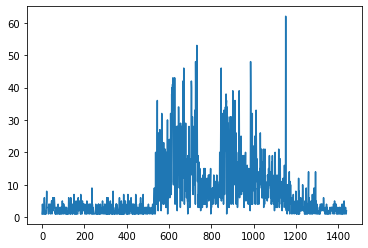

In [132]:
import matplotlib.pyplot as plt
plt.plot(X,y)
plt.show()

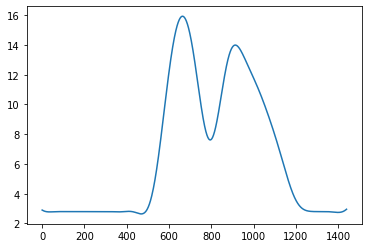

In [133]:
plt.plot(X,regr.predict(X))
plt.show()

In [136]:
regr.predict([[800]])

array([7.65555882])

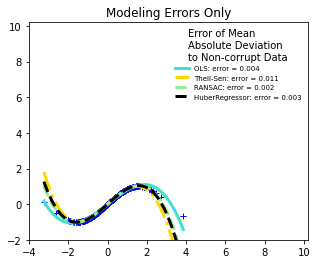

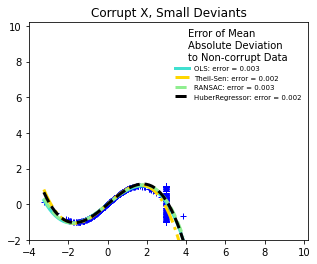

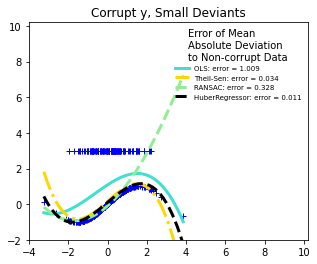

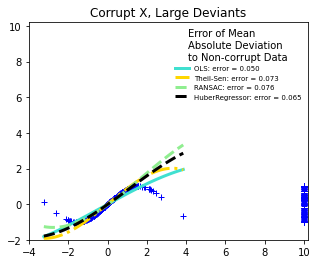

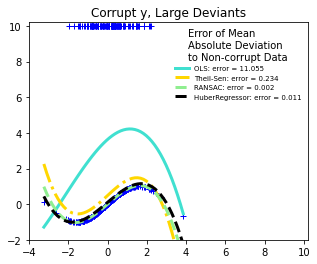

In [28]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
    ("HuberRegressor", HuberRegressor()),
]
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "HuberRegressor": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "HuberRegressor": "--"}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, "b+")

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )

    legend_title = "Error of Mean\nAbsolute Deviation\nto Non-corrupt Data"
    legend = plt.legend(
        loc="upper right", frameon=False, title=legend_title, prop=dict(size="x-small")
    )
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

In [137]:
root = r'D:\pycode2\ML-for-SQL-Injection-master\datas\archive/'

In [149]:
import os
sum = 0
for i in os.listdir(root):
    df = pd.read_csv(root+i)
    sum+=len(df)
print(sum)

209317


In [148]:
df = pd.read_csv(root+'sqli.csv')

In [150]:
209317+22754

232071